## Rohlik Orders Forecasting Challenge
Use historical data to predict customer orders

### Variables Intro:
train.csv

* `warehouse` - warehouse name
* `date` - date
* `orders` - number of customer orders attributed to the warehouse
* `holiday_name` - name of public holiday if any
* `holiday` - 0/1 indicating the presence of holidays
* `shutdown` - warehouse shutdown or limitation due to operations (not provided in test)
* `shops_closed` - public holiday with most of the shops or large part of shops closed
* `winter_school_holidays` - school holidays
* `school_holidays` - school holidays
* `precipitation` - precipitation in mm around the location of the warehouse which correlates with location of the customers (not provided in test)
* `snow` - snowfall in mm around the location of the warehouse which correlates with location of the customers (not provided in test)
* `user_activity_1` - user activity on the website (not provided in test)
* `user_activity_2` - user activity on the website (not provided in test)
* `id` - row id consisting of warehouse name and date

In [36]:
!pip install catboost
!pip install skimpy

### EDA

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimpy
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Ignore Warnings
# To avoid warnings cluttering the output, we disable them here
import warnings
warnings.simplefilter("ignore")



In [38]:
# Data Loading
# Load training and testing datasets
train_df = pd.read_csv('input/rohlik-orders-forecasting-challenge/train.csv')
test_df = pd.read_csv('input/rohlik-orders-forecasting-challenge/test.csv')

In [39]:
# View summary of data
initial_features = list(test_df.columns)
target = 'orders'
skimpy.skim(train_df[initial_features+[target]])


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7340   │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 9      │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA  ┃ NA %  ┃ mean      ┃ sd       ┃ p0   ┃ p25   ┃ p50  ┃ p75  ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ holiday                 │   0 │     0 │   0.02725 │   0.1628 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ shops_closed            │   0 │     0 │    0.0109 │   0.1038 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ winter_school_holidays  │   0 │     0 │   0.02997 │   0.1705 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ school_holidays         │   0 │     0 │  0.007084 │  0.08388 │    0 │     0 │    0 │    0 │     1 │   ▇    │  │
│ │ orders                  │   0 │     0 │      5535 │     2183 │  790 │  4434 │ 5370 │ 7009 │ 18140 │  ▂▇▅▁  │  │
│ └─────────────────────────┴─────┴───────┴───────────┴──────────┴──────┴───────┴──────┴──────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA         ┃ NA %        ┃ words per row              ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ warehouse                 │          0 │           0 │                          1 │                   7340 │  │
│ │ date                      │          0 │           0 │                          1 │                   7340 │  │
│ │ holiday_name              │       7122 │       97.03 │                      0.095 │                    697 │  │
│ │ id                        │          0 │           0 │                          1 │                   7340 │  │
│ └───────────────────────────┴────────────┴─────────────┴────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [40]:
skimpy.skim(test_df)


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 397    │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ mean      ┃ sd       ┃ p0  ┃ p25  ┃ p50  ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ holiday                   │   0 │      0 │   0.06801 │   0.2521 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ │ shops_closed              │   0 │      0 │   0.02015 │   0.1407 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ winter_school_holidays    │   0 │      0 │   0.02015 │   0.1407 │   0 │    0 │    0 │    0 │    1 │   ▇    │  │
│ │ school_holidays           │   0 │      0 │   0.07053 │   0.2564 │   0 │    0 │    0 │    0 │    1 │ ▇    ▁ │  │
│ └───────────────────────────┴─────┴────────┴───────────┴──────────┴─────┴──────┴──────┴──────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA       ┃ NA %         ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ warehouse                 │        0 │            0 │                           1 │                    397 │  │
│ │ date                      │        0 │            0 │                           1 │                    397 │  │
│ │ holiday_name              │      380 │        95.72 │                         0.1 │                     40 │  │
│ │ id                        │        0 │            0 │                           1 │                    397 │  │
│ └───────────────────────────┴──────────┴──────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [41]:
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df['date'])
    df['holiday_name'] = df['holiday_name'].fillna('None')


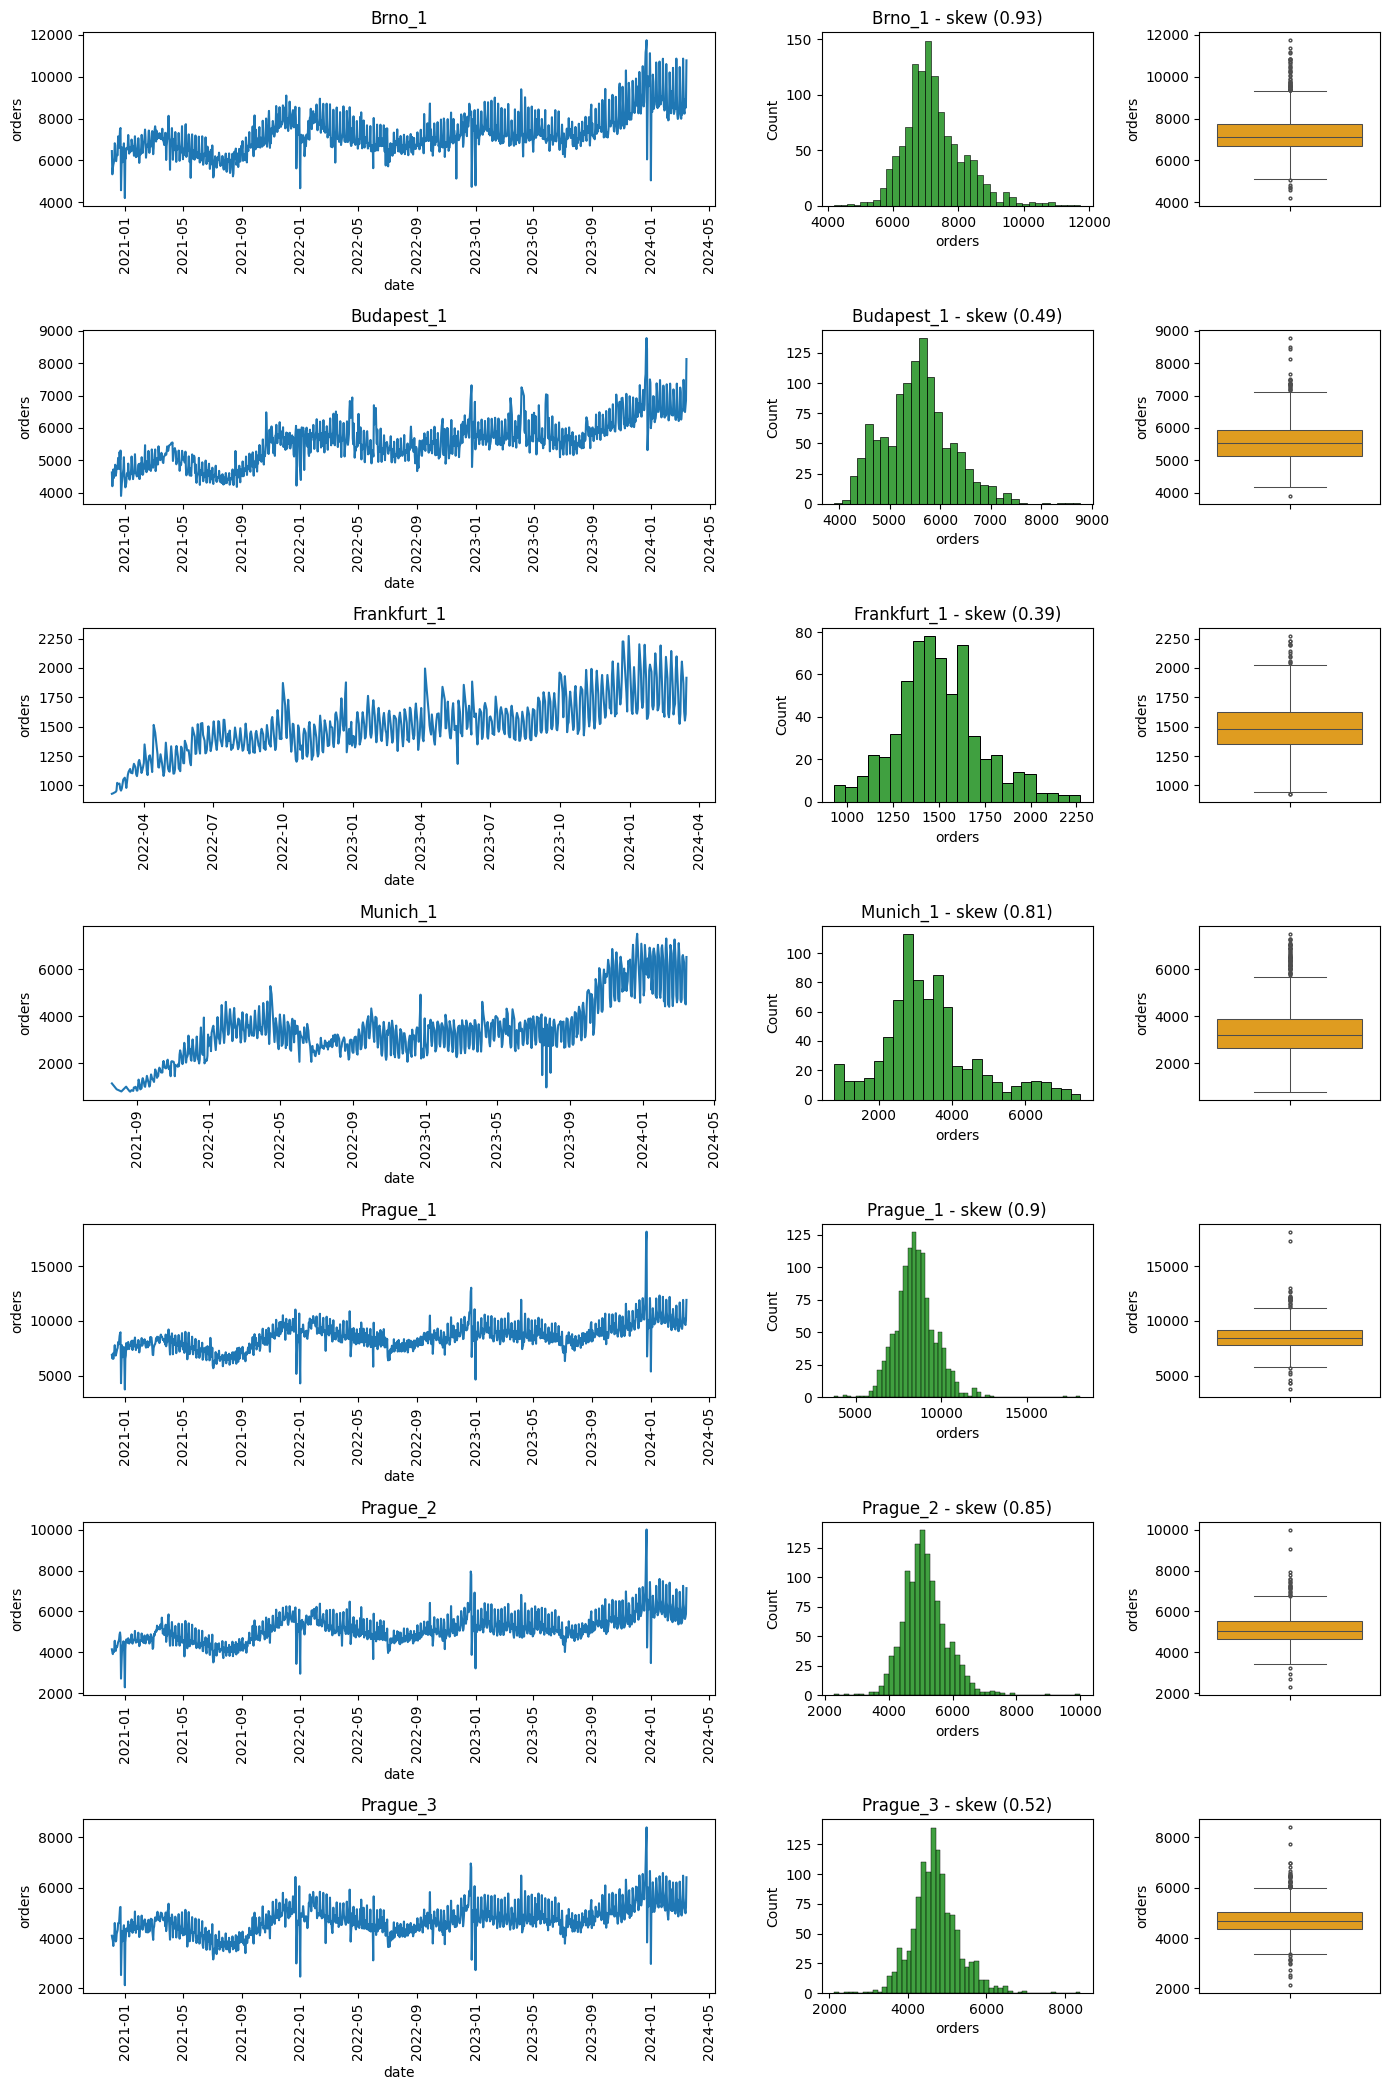

In [42]:
fig, axes = plt.subplots(7,3, figsize=(14,7*3), gridspec_kw={'width_ratios':[0.70, 0.30, 0.20 ]})

for i,(ind, c) in enumerate(train_df.groupby('warehouse')):
    ax = axes[i,0]
    sns.lineplot(data=c,x=c.date,y='orders',ax=ax)
    ax.set_title(f'{ind}')
    ax.tick_params(axis='x', rotation=90)


    ax = axes[i,1]
    sns.histplot(data=c,x='orders',ax=ax,color='green')
    ax.set_title(f'{ind} - skew ({c.orders.skew().round(2)})')

    ax = axes[i,2]
    sns.boxplot(data=c,y='orders',ax=ax,color='orange', linewidth=.75, fliersize=2.01, width=0.80)

plt.tight_layout()

Text(0.5, 1.0, 'Target distribuition')

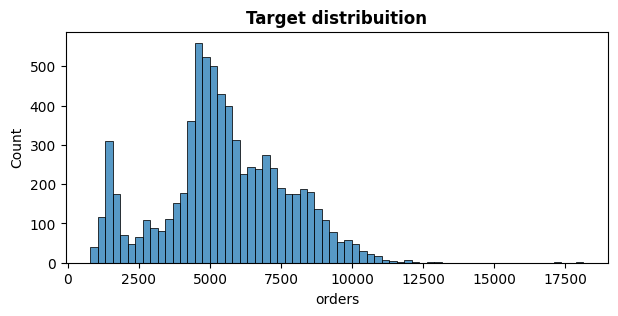

In [43]:
plt.figure(figsize=(7,3))
sns.histplot(train_df['orders']);
plt.title('Target distribuition',fontweight='bold')


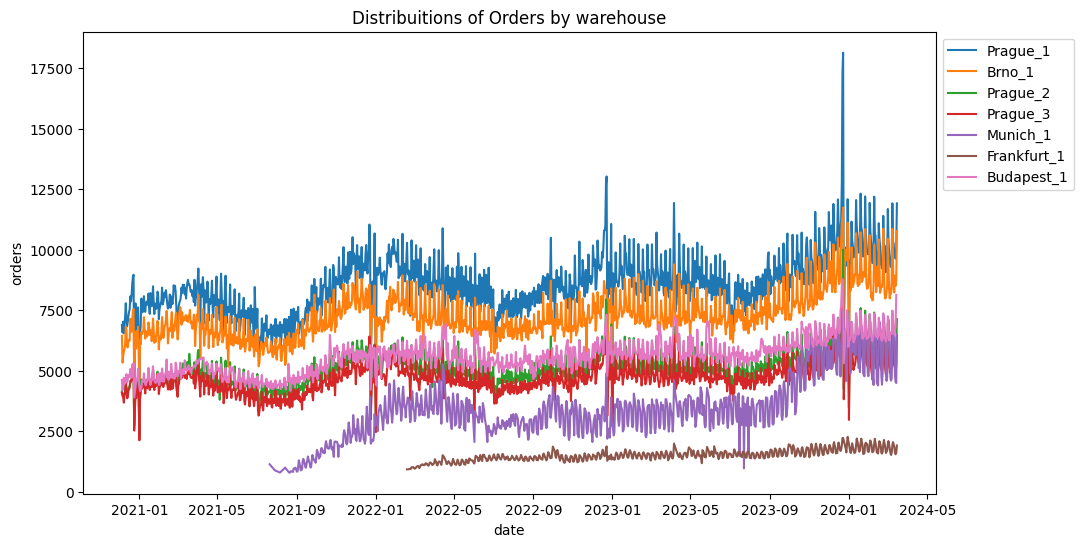

In [44]:
_, ax = plt.subplots(figsize=(11,6))
sns.lineplot(data=train_df,x='date',
             y='orders',
             errorbar=None,
             hue='warehouse',
             palette='tab10',ax=ax);
ax.legend(bbox_to_anchor=[1, 1]);
ax.set_title('Distribuitions of Orders by warehouse');

### Preprocessing

In [45]:
# Save Test IDs
# Store the 'id' column from the test set for later use in submission
test_id = test_df['id']

# Convert 'date' column to datetime format in the training data
train_df['date'] = pd.to_datetime(train_df['date'])

# Fill missing values in 'holiday_name' column with 'None'
train_df['holiday_name'].fillna('None', inplace=True)
test_df['holiday_name'].fillna('None', inplace=True)

In [46]:
# Select base features from test data (excluding 'id')
base_features = test_df.drop(columns=['id']).columns

# Combine training and testing datasets for uniform preprocessing
train_df = pd.concat([train_df[base_features], train_df['orders']], axis=1)
test_df = test_df[base_features]

# Merge Data for Preprocessing
# Combine both datasets to apply transformations consistently
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [47]:
# Feature Engineering - Date
# Extract year, month, day, and day of the week from the 'date' column
date_col = ['date']
for _col in date_col:
    date_col = pd.to_datetime(all_df[_col], errors='coerce')
    all_df[_col + "_year"] = date_col.dt.year.fillna(-1)
    all_df[_col + "_month"] = date_col.dt.month.fillna(-1)
    all_df[_col + "_day"] = date_col.dt.day.fillna(-1)
    all_df[_col + "_day_of_week"] = date_col.dt.dayofweek.fillna(-1)
    all_df.drop(_col, axis=1, inplace=True)

# Fill missing 'holiday_name' values
all_df['holiday_name'].fillna('None', inplace=True)


In [48]:
# Encoding Categorical Features
# One-Hot Encoding for 'holiday_name' column
enc = OneHotEncoder(sparse=False)
holiday_encoded = enc.fit_transform(all_df[['holiday_name']])
encoded_df = pd.DataFrame(holiday_encoded, columns=enc.get_feature_names_out(['holiday_name']))
all_df = pd.concat([all_df, encoded_df], axis=1)
all_df = all_df.drop('holiday_name', axis=1)

# Label Encoding for 'warehouse' column
le = preprocessing.LabelEncoder()
all_df['warehouse'] = le.fit_transform(all_df['warehouse'])

In [49]:
# Split Data Back into Train and Test
# Separate the combined dataset back into training and test sets
train_df_le = all_df[~all_df['orders'].isnull()]
test_df_le = all_df[all_df['orders'].isnull()]

# Features and Target Separation
# Separate features (X) and target variable (y)
X = train_df_le.drop(columns=['orders'])
y = train_df_le['orders']

# Train-Test Split
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)


### An overview on single model performance

In [50]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.pipeline import Pipeline

In [51]:
# Initialize models
models = {
    'XGBRegressor': XGBRegressor(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    'LGBMRegressor': LGBMRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'ExtraTreeRegressor': ExtraTreeRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    # 'CatBoostRegressor':CatBoostRegressor()
}

# Initialize list to hold MAPE results
mape_results = []

# Train, predict, and calculate MAPE for each model
for model_name, model in models.items():
    # Create a pipeline with standard scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on validation set
    pred_val = pipeline.predict(X_val)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val, pred_val)

    # Append results
    mape_results.append({'Model': model_name, 'MAPE': mape})

# Convert results to DataFrame for better readability
mape_df = pd.DataFrame(mape_results)

# Format MAPE to 5 decimal places
mape_df['MAPE'] = mape_df['MAPE'].apply(lambda x: f"{x:.5f}")

# Sort by MAPE
mape_df = mape_df.sort_values(by='MAPE')

# Print MAPE results
print("MAPE Results for Each Model:")
print(mape_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 10
[LightGBM] [Info] Start training from score 5542.194142
MAPE Results for Each Model:
                            Model     MAPE
0                    XGBRegressor  0.03999
1   HistGradientBoostingRegressor  0.04350
2                   LGBMRegressor  0.04351
3           RandomForestRegressor  0.04466
5             ExtraTreesRegressor  0.04648
4                BaggingRegressor  0.04683
7           DecisionTreeRegressor  0.05791
8              ExtraTreeRegressor  0.06048
6       GradientBoostingRegressor  0.07577
10            KNeighborsRegressor  0.20452
9               AdaBoostRegressor  0.23595


### Pick your model and do hyper-parameter tuning

In [52]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBRegressor model
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val, y_pred)


# Print MAPE
print(f"\nMAPE for XGBRegressor: {mape:.5f}")



MAPE for XGBRegressor: 0.03928


#### Grid Search

In [53]:
# %%timeit
from sklearn.model_selection import GridSearchCV

tuned_parameters = [
    {
    'colsample_bytree': [0.8, 0.9],
    'learning_rate': [0.1, 0.15, 0.2],
    'max_depth': [6,7,8],
    # 'min_child_weight': [3,4,5],
    # 'n_estimators': [200, 250],
    # 'subsample': [0.9, 0.95]
}
]


grid_search = GridSearchCV(
    XGBRegressor(), tuned_parameters
)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 8}


#### Random Search

In [54]:
# specify parameters and distributions to sample from
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'colsample_bytree': stats.uniform(0.7, 0.9),
    'learning_rate': stats.uniform(0.1, 0.25),
    'max_depth': [6,7,8],

}

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(
    XGBRegressor(), param_distributions=param_dist, n_iter=n_iter_search
)

random_search.fit(X_train, y_train)
print(random_search.best_params_)

{'colsample_bytree': 0.7068721696405327, 'learning_rate': 0.3001531823986143, 'max_depth': 8}


#### Print feature importances

In [55]:
# Print feature importances
feature_importances = model.feature_importances_
features = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])

print("\nFeature Importances:")
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df


Feature Importances:


,Feature,Importance
0,warehouse,0.622150
30,holiday_name_New Years Day,0.092631
5,date_year,0.072311
12,holiday_name_Christmas Eve,0.047119
6,date_month,0.032187
1,holiday,0.025168
2,shops_closed,0.024899
8,date_day_of_week,0.021119
16,holiday_name_Den ceske statnosti,0.015761
17,holiday_name_Den osvobozeni,0.013576


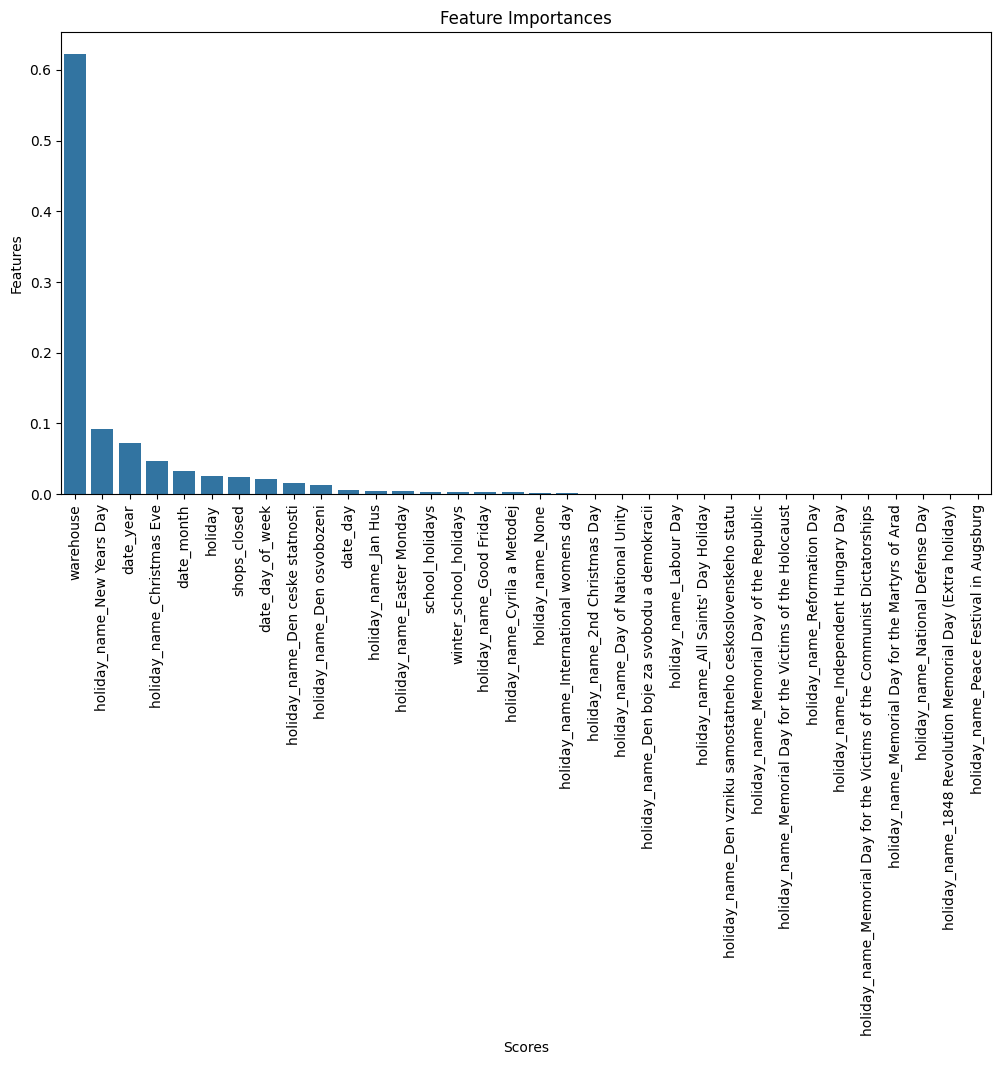

In [56]:
from matplotlib import pyplot as plt
# plot feature importance scores
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Feature'], y=importance_df['Importance'])
plt.xlabel('Scores')
plt.ylabel('Features')
plt.tick_params(axis='x', rotation=90)
plt.title('Feature Importances')
plt.show()

#### choose final model and predict

In [57]:
# Define the best hyperparameters
best_params = {
    'colsample_bytree': 0.88,
    'learning_rate': 0.2,
    'max_depth': 9,
    'min_child_weight': 5,
    'n_estimators': 250,
    'subsample': 0.9
}

# Initialize and train the XGBRegressor model with best hyperparameters
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val, y_pred)

# Print MAPE
print(f"\nMAPE for Optimized XGBRegressor: {mape:.5f}")


MAPE for Optimized XGBRegressor: 0.03885


In [58]:
# Make predictions on the test set
pred_test = model.predict(test_df_le.drop(columns=['orders']))

# Prepare the submission file
submission = pd.DataFrame({
    'id': test_id,
    'orders': pred_test
})

# Save the predictions to a CSV file
# submission.to_csv('submission.csv', index=False)

# Print the submission DataFrame
print(submission)

                        id        orders
0      Prague_1_2024-03-16  10277.794922
1      Prague_1_2024-03-17   9910.810547
2      Prague_1_2024-03-18   9665.434570
3      Prague_1_2024-03-19   9530.706055
4      Prague_1_2024-03-20   9278.515625
..                     ...           ...
392  Budapest_1_2024-05-11   7294.337402
393  Budapest_1_2024-05-12   6681.571289
394  Budapest_1_2024-05-13   6592.458008
395  Budapest_1_2024-05-14   6943.616211
396  Budapest_1_2024-05-15   6592.837891

[397 rows x 2 columns]


### Stacking models via meta-learner

In [59]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor

# Ignore warnings
import warnings
warnings.simplefilter("ignore")

# Load data
train_df = pd.read_csv('input/rohlik-orders-forecasting-challenge/train.csv')
test_df = pd.read_csv('input/rohlik-orders-forecasting-challenge/test.csv')

# Save Test IDs
test_id = test_df['id']

# Convert date column to datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Transform categorical variables
train_df['holiday_name'].fillna('None', inplace=True)
test_df['holiday_name'].fillna('None', inplace=True)

# Review basic features
base_features = test_df.drop(columns=['id']).columns

# Combine train and test datasets
train_df = pd.concat([train_df[base_features], train_df['orders']], axis=1)
test_df = test_df[base_features]

# Combine data
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

# Convert date column to a processable format
date_col = ['date']
for _col in date_col:
    date_col = pd.to_datetime(all_df[_col], errors='coerce')
    all_df[_col + "_year"] = date_col.dt.year.fillna(-1)
    all_df[_col + "_month"] = date_col.dt.month.fillna(-1)
    all_df[_col + "_day"] = date_col.dt.day.fillna(-1)
    all_df[_col + "_day_of_week"] = date_col.dt.dayofweek.fillna(-1)
    all_df.drop(_col, axis=1, inplace=True)

# Replace null values with None
all_df['holiday_name'].fillna('None', inplace=True)

# OneHotEncoding → holiday_name
enc = OneHotEncoder(sparse=False)
holiday_encoded = enc.fit_transform(all_df[['holiday_name']])
encoded_df = pd.DataFrame(holiday_encoded, columns=enc.get_feature_names_out(['holiday_name']))
all_df = pd.concat([all_df, encoded_df], axis=1)
all_df = all_df.drop('holiday_name', axis=1)

# LabelEncoding → warehouse
le = preprocessing.LabelEncoder()
all_df['warehouse'] = le.fit_transform(all_df['warehouse'])

# Split data back into train and test sets
train_df_le = all_df[~all_df['orders'].isnull()]
test_df_le = all_df[all_df['orders'].isnull()]

# Separate features and target variable
X = train_df_le.drop(columns=['orders'])
y = train_df_le['orders']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Define models
models = {
    'LGBM': LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'HistGradientBoosting': HistGradientBoostingRegressor()
}

# Train models
pred_train = pd.DataFrame()
pred_val = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_train[name] = model.predict(X_train)
    pred_val[name] = model.predict(X_val)

# Meta model for stacking
#meta_model = LGBMRegressor(n_estimators=100, learning_rate=0.15, random_state=42)
meta_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

meta_model.fit(pred_train, y_train)

# Predict on validation set and calculate MAPE
final_pred_val = meta_model.predict(pred_val)
mape = mean_absolute_percentage_error(y_val, final_pred_val)
print(f'Stacking Ensemble Model MAPE: {mape:.4f}')

# Predict on test set and prepare submission file
pred_test = pd.DataFrame()

for name, model in models.items():
    pred_test[name] = model.predict(test_df_le.drop(columns=['orders']))

final_pred_test = meta_model.predict(pred_test)

# Create submission file
submission = pd.DataFrame({
    'id': test_id,
    'orders': final_pred_test
})

# Save the file
# submission.to_csv('submission.csv', index=False)
print(submission)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 6606, number of used features: 11
[LightGBM] [Info] Start training from score 5525.432183
Stacking Ensemble Model MAPE: 0.0366
                        id        orders
0      Prague_1_2024-03-16  10370.987305
1      Prague_1_2024-03-17  10215.574219
2      Prague_1_2024-03-18   9754.144531
3      Prague_1_2024-03-19   9320.852539
4      Prague_1_2024-03-20   9320.852539
..                     ...           ...
392  Budapest_1_2024-05-11   6918.728027
393  Budapest_1_2024-05-12   6534.725098
394  Budapest_1_2024-05-13   6522.892090
395  Budapest_1_2024-05-14   6790.010742
396  Budapest_1_2024-05-15

### Visualize Result

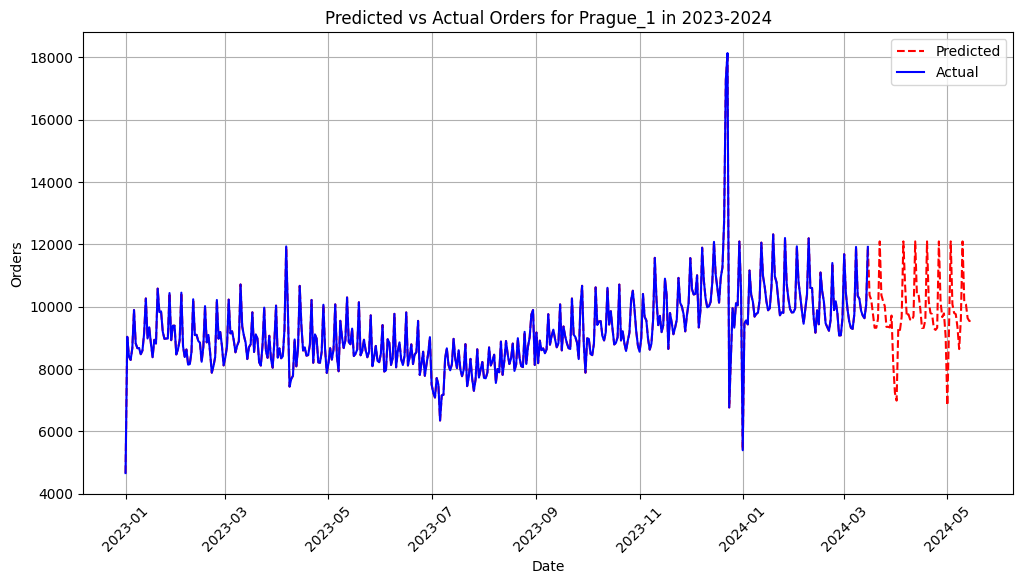

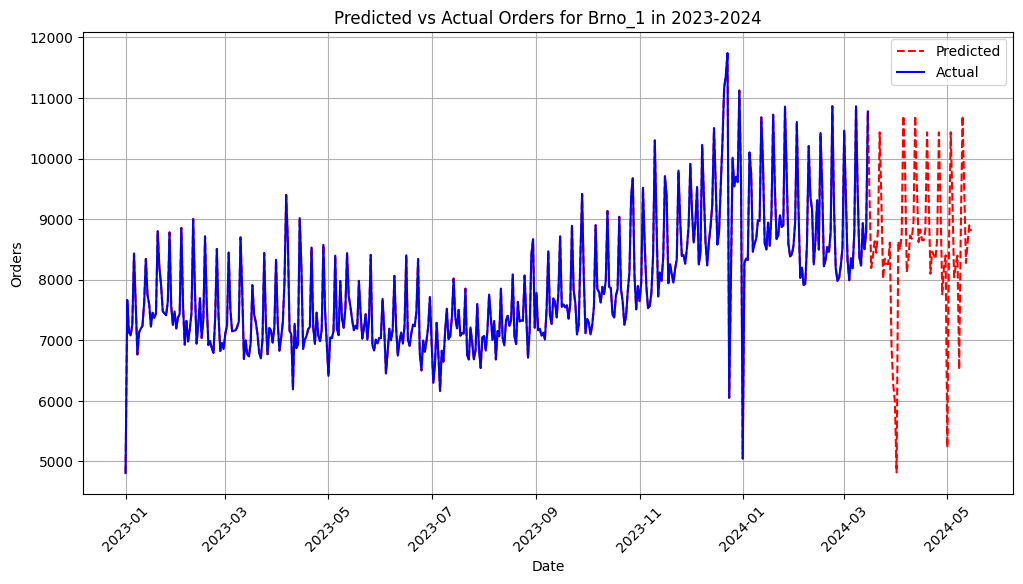

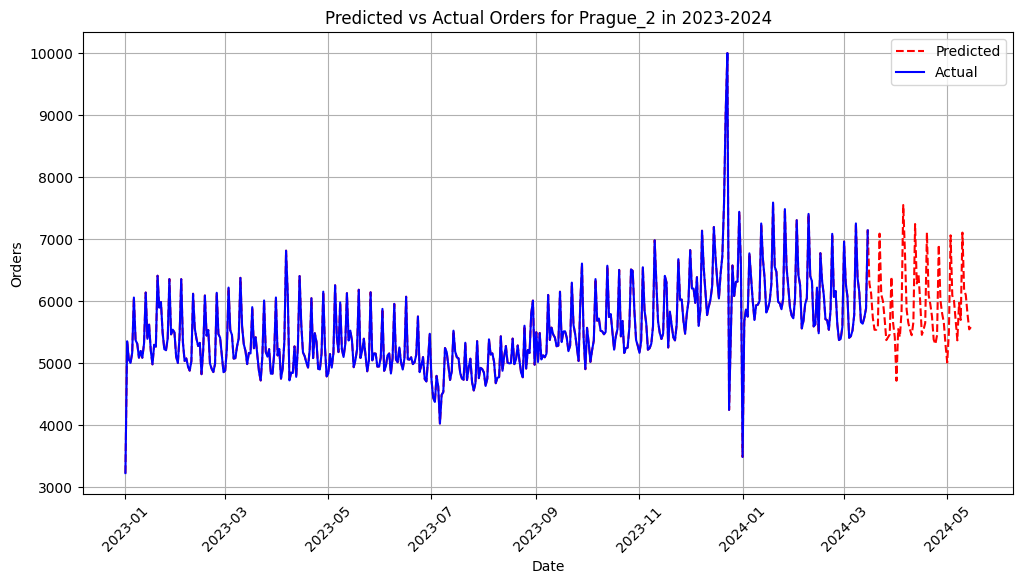

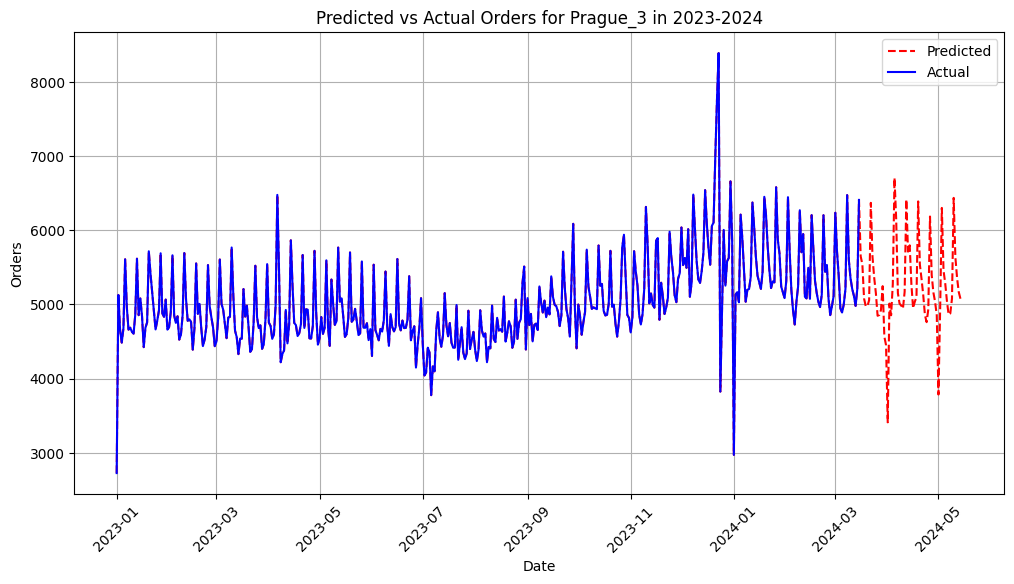

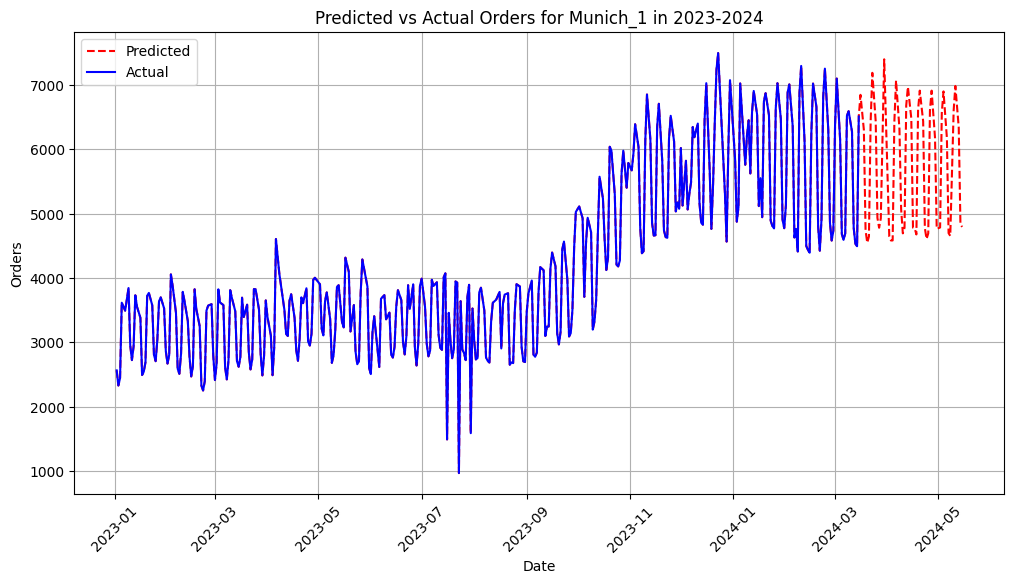

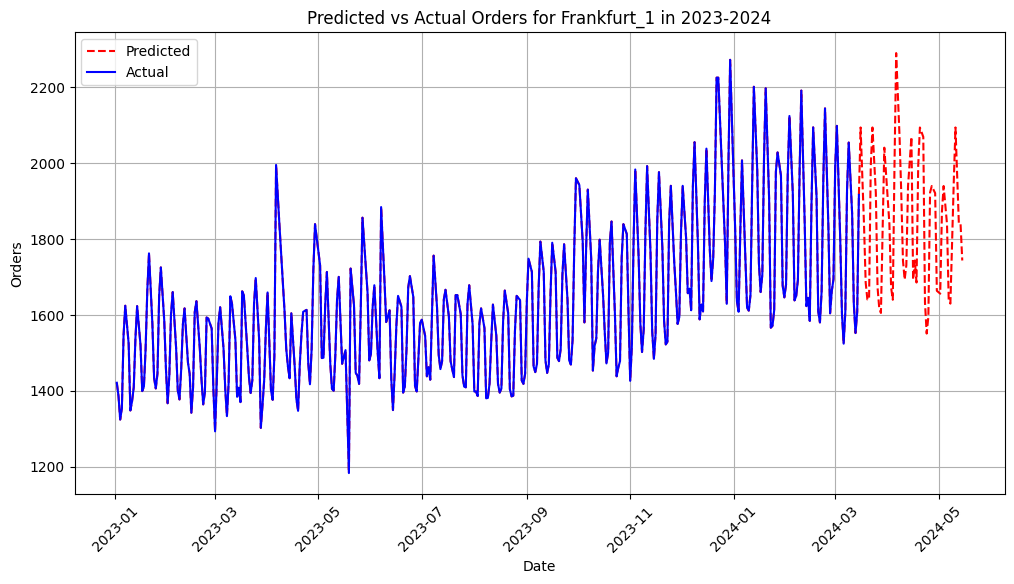

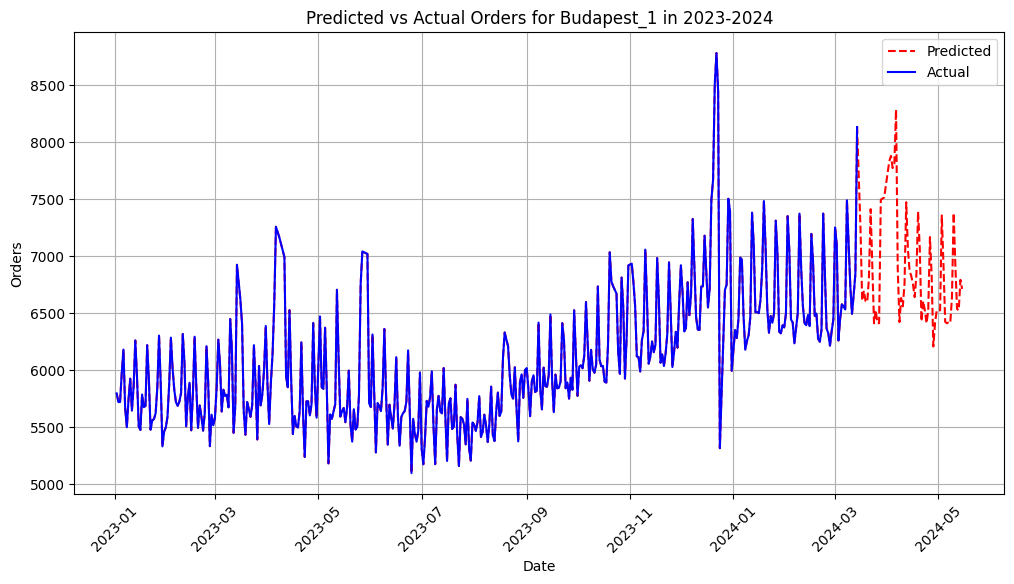

Predictions complete. Submission file and plots created.


In [60]:
# Plot predictions for each warehouse
train_df_raw = pd.read_csv("input/rohlik-orders-forecasting-challenge/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]
warehouses = train_df_raw['warehouse'].unique()

temp = pd.concat([test_df.reset_index(),submission], axis=1).drop(columns=['index'])
temp = pd.concat([last_year_data, temp]).reset_index()
temp['date'] = pd.to_datetime(temp['date'])


for wh in warehouses:

    wh_df_pred = temp[temp['warehouse'] == wh]
    wh_df_pred = wh_df_pred.sort_values(by=['date'])
    wh_df_last_year = last_year_data[last_year_data['warehouse'] == wh]
    wh_df_last_year = wh_df_last_year.sort_values(by=['date'])

    # Plot data (training data from 2023)

    plt.figure(figsize=(12, 6))

    plt.plot(wh_df_pred.date, wh_df_pred['orders'], label='Predicted',  linestyle='--', color='red')

    plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

    plt.title(f'Predicted vs Actual Orders for {wh} in 2023-2024')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    # plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()
